In [1]:
import pandas as pd

# ======================================================
# PRE-ANÁLISIS DE ARCHIVO DE SALIDA WRF (T2 y RH2)
# ======================================================
# Este script revisa las características básicas de un archivo
# PKL generado en la extracción de datos (Día 1, Año 2015 en este ejemplo).
#
# Objetivos:
#   1. Verificar estructura y tipos de datos.
#   2. Revisar un ejemplo de las primeras filas.
#   3. Comprobar coordenadas disponibles.
#   4. Obtener el rango de fechas.
#   5. Contar registros y puntos únicos.
#
# Nota: El archivo debe existir localmente o en el entorno de trabajo.
# ======================================================

# Ruta al archivo PKL de entrada
archivo_pkl = "WRF_DataT2RH2-allxy-allTime_dia1_2015.pkl"

# === 1. Cargar archivo ===
df = pd.read_pickle(archivo_pkl)

# === 2. Información general ===
print("Información del DataFrame:")
print(df.info())

# === 3. Primeras filas de datos ===
print("\nPrimeras filas del archivo:")
print(df.head())

# === 4. Coordenadas únicas disponibles (mostrar 10 ejemplos) ===
print("\nCoordenadas únicas disponibles:")
print(df[['lat', 'lon']].drop_duplicates().head(10))

# === 5. Rango de fechas ===
print("\nRango de fechas:")
print(f"Desde: {df['fecha_modelo'].min()}  Hasta: {df['fecha_modelo'].max()}")

# === 6. Cantidad total de filas y puntos únicos ===
print("\nCantidad total de filas:", len(df))
print("Número de puntos únicos:", len(df[['lat', 'lon']].drop_duplicates()))


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5070107 entries, 0 to 5070106
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   fecha_modelo  object 
 1   hora          int64  
 2   lat           float32
 3   lon           float32
 4   HGT           float64
 5   T2            float64
 6   RH2           float64
dtypes: float32(2), float64(3), int64(1), object(1)
memory usage: 232.1+ MB
None

Primeras filas del archivo:
  fecha_modelo  hora        lat        lon         HGT         T2        RH2
0   2015-01-02     0 -33.178204 -71.683090  189.884247  15.791901  70.491035
1   2015-01-02     0 -33.178204 -71.672699  252.514252  15.819397  69.495125
2   2015-01-02     0 -33.178204 -71.662315  311.148193  15.847504  68.565086
3   2015-01-02     0 -33.178204 -71.651932  363.760681  15.876190  67.763191
4   2015-01-02     0 -33.178204 -71.641541  407.532715  15.905548  66.862099

Coordenadas únicas disponibles:
         lat 

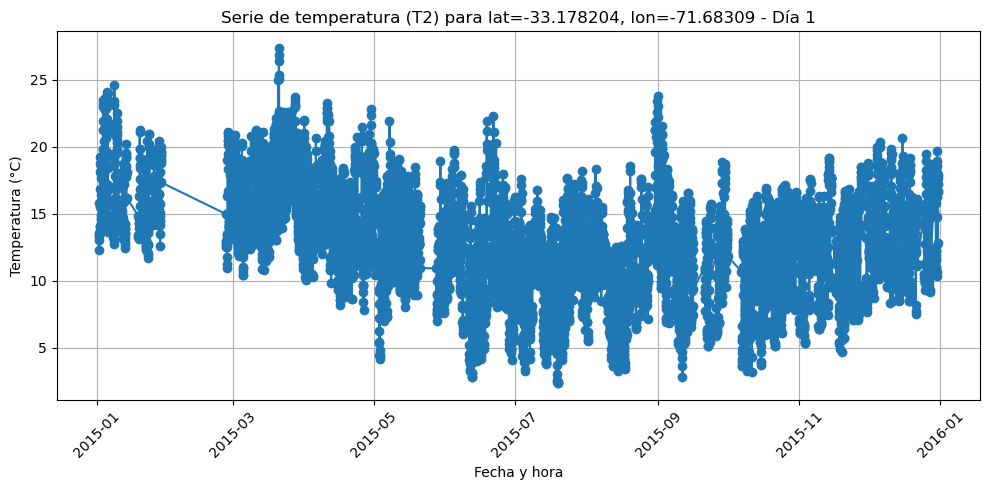

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# ======================================================
# GRAFICAR SERIE DE TIEMPO DE UNA VARIABLE EN PUNTO ESPECÍFICO
# ======================================================
# Este bloque grafica la serie de tiempo de la variable T2 (°C)
# para una coordenada específica de latitud y longitud, usando
# los datos de un archivo PKL generado en la extracción.
#
# Pasos:
#   1. Cargar archivo de salida.
#   2. Filtrar los registros de un punto específico (lat, lon).
#   3. Construir una columna datetime.
#   4. Graficar la serie de tiempo.
# ======================================================

# === 1. Cargar archivo ===
archivo_pkl = "WRF_DataT2RH2-allxy-allTime_dia1_2015.pkl"
df = pd.read_pickle(archivo_pkl)

# === 2. Elegir coordenada específica ===
# ⚠ Cambiar estos valores según el punto a analizar
lat_obj = -33.178204
lon_obj = -71.683090

# Filtrar por coordenada exacta
df_sel = df[(df['lat'] == lat_obj) & (df['lon'] == lon_obj)].copy()

# Crear columna datetime para graficar
df_sel['datetime'] = pd.to_datetime(df_sel['fecha_modelo'].astype(str)) + pd.to_timedelta(df_sel['hora'], unit='h')

# === 3. Graficar serie de tiempo de T2 ===
plt.figure(figsize=(10, 5))
plt.plot(df_sel['datetime'], df_sel['T2'], marker='o')
plt.title(f"Serie de temperatura (T2) para lat={lat_obj}, lon={lon_obj} - Día 1")
plt.xlabel("Fecha y hora")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import branca.colormap as cm

# ======================================================
# MAPA DE PUNTOS DEL DOMINIO PARA UNA HORA ESPECÍFICA
# ======================================================
# Este bloque visualiza en Folium los valores de T2 y RH2
# para todos los puntos de un archivo PKL en una hora dada.
# Usa un colormap continuo para no limitar la escala a pocos rangos.
# ======================================================

# === 1. Cargar archivo ===
archivo_pkl = "WRF_DataT2RH2-allxy-allTime_dia1_2015.pkl"
df = pd.read_pickle(archivo_pkl)

# === 2. Filtrar por hora específica (ejemplo: 12:00) ===
hora_obj = 12
df_sel = df[df['hora'] == hora_obj].copy()

# === 3. Crear GeoDataFrame ===
gdf = gpd.GeoDataFrame(
    df_sel,
    geometry=gpd.points_from_xy(df_sel['lon'], df_sel['lat']),
    crs="EPSG:4326"
)

# === 4. Función para crear mapa de una variable ===
def mapa_variable(gdf, variable, titulo, archivo_salida):
    # Crear colormap continuo según el rango de la variable
    min_val, max_val = gdf[variable].min(), gdf[variable].max()
    colormap = cm.linear.viridis.scale(min_val, max_val)

    # Crear mapa centrado
    centro = [gdf["lat"].mean(), gdf["lon"].mean()]
    m = folium.Map(location=centro, zoom_start=8, tiles="CartoDB positron")

    # Añadir puntos con colores según el valor
    for _, row in gdf.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=3,
            color=colormap(row[variable]),
            fill=True,
            fill_opacity=0.8,
            weight=0
        ).add_to(m)

    # Añadir colormap y título
    colormap.caption = titulo
    colormap.add_to(m)

    # Guardar mapa
    m.save(archivo_salida)
    print(f"[OK] Mapa guardado: {archivo_salida}")

# === 5. Generar mapas para T2 y RH2 ===
mapa_variable(gdf, "T2", f"Temperatura (°C) a las {hora_obj}:00", f"mapa_T2_{hora_obj}h.html")
mapa_variable(gdf, "RH2", f"Humedad Relativa (%) a las {hora_obj}:00", f"mapa_RH2_{hora_obj}h.html")

